In [1]:
library(tidyverse)
library(reshape) #melt
library(nFactors) #optimal number of components
library(corrplot)
library(RColorBrewer)
library(mgsub)
library(igraph)
library(ggraph)

Warning message:
"程辑包'tidyverse'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'ggplot2'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'tibble'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'tidyr'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'readr'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'purrr'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'dplyr'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'forcats'是用R版本4.1.3 来建造的"
Warning message:
"程辑包'lubridate'是用R版本4.1.3 来建造的"
-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.0     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.4.1     v tibble    3.1.7
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"程辑包'reshape'是用R版本4.1.3 来建造的"

载入程辑包：'res

In [2]:
plotnScree <- function (nScree,
       elbow = 3,
       legend = TRUE,
       ylab   = "Eigenvalues",
       xlab   = "Components",
       main   = "Non Graphical Solutions to Scree Test")
       {
       if (!inherits(nScree, "nScree"))  stop("Method is only for nScree objects")
       #if (!exists("legend", mode="logical") ) legend <- TRUE                                   # To develop
       #if (!exists("ylab"))                    ylab <- "Eigenvalues"                            # To develop
       #if (!exists("xlab"))                    xlab <- "Components"                             # To develop
       #if (!exists("main"))                    main <- "Non Graphical Solutions to Scree Test"  # To develop
       if (nScree$Model == "components") nkaiser = "Eigenvalues (>mean  = " else nkaiser = "Eigenvalues (>0 = "
       if (nScree$Model == "factors")  xlab   = "Factors"
       # panel
       par(col   = 1, pch = 1, cex=4)     # Color and symbol for usual scree
       par(mfrow = c(1,1),lwd=2, cex=4)
       eig        <- nScree$Analysis$Eigenvalues
       k          <- 1:length(eig)
       #plotuScree(x=eig, ...)                                                                   # To develop
       plotuScree(x=eig, main=main, xlab=xlab, ylab=ylab,col=2)
       nk         <- length(eig)
       noc        <- nScree$Components$noc
       vp.p       <- lm(eig[c(noc+1,nk)] ~ k[c(noc+1,nk)])
       x          <- sum(c(1,1) * coef(vp.p))
       y          <- sum(c(1,nk)* coef(vp.p))
       par(col = 10, cex=1.8)            # Color for optimal coordinates
       lines(k[c(1,nk)],c(x,y),lwd=1.8)
       par(col = 11,pch=2, cex=1.5)            # Color and symbol for parallel analysis
       lines(1:nk, nScree$Analysis$Par.Analysis, type = "b",lwd=1.8)
       if (legend == TRUE) {
       leg.txt  <- c(paste("Parallel Analysis (n = ",nScree$Components$nparallel,")"),
              c(paste("Kaiser-Guttman rule (n = ",nScree$Components$nkaiser,")")),
              c(paste("Cattell’s scree test (n = ",elbow,")")),
              c(paste("Optimal Coordinates (n = ",nScree$Components$noc,")")) )
       legend("topright",
       legend   = leg.txt,
       pch      = c('△','_','○','_'),
       text.col = c(3,4,1,2), 
       col = c(3,4,1,2),
       cex = 1)
       }
       naf        <-   nScree$Components$naf
       text(x = noc ,    y = eig[noc],     label = " (OC)", cex = 1.2, adj = c(0,0), col = 2)
       #    text(x = naf + 1, y = eig[naf + 1], label = " (AF)", cex = .70, adj = c(0,0), col = 4)
       }

# R.scale() uses ddof=1, but sklearn.preprocessing.StandardScaler() uses ddof=0 
scaleN <- function(data){
       data_scaled <- scale(data)*sqrt(nrow(data)/(nrow(data)-1))
       return(as.data.frame(data_scaled))
       }

FAVEE <- function(data, names = c('Activeness','Formality','Equality','Exchange','Valence')){
       data.pca = prcomp(data)
       ncomp = 5

       loadings_none = data.pca$rotation[,1:ncomp]%*% diag(data.pca$sdev,ncomp,ncomp)
       scores_none = data.pca$x[,1:ncomp] 

       loadings_var = varimax(loadings_none)$loadings
       scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

       loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])

       #filter each row's max loading, and attribute it to correspnding column.
       order_list = c()
       for (row in c(1:nrow(loadings_var_reorder))){
       temp_max = abs(loadings_var_reorder[row,1])
       n = 1
       for (col in c(2:ncomp)){
              temp = abs(loadings_var_reorder[row,col])
              if (temp > temp_max){
              temp_max = temp
              n = col
              }
              
       }
       order_list[row] = n
       }
       loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
       RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1)
       RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(V2)
       RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3)
       RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4)
       RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(V5))

       loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
       loadings_var_reorder = loadings_var_reorder[1:5]

       colnames(loadings_var_reorder) = names
       colnames(scores_var) = colnames(loadings_var_reorder)
       
       options(repr.plot.width=6, repr.plot.height=10)
       my.breaks = c(seq(-1,1,by=0.01))
       corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
              tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
              col.lim = c(-1.1,1.1),cl.ratio = 0.4,cl.cex=1,
              col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))
       
       scores_var = data.frame(scores_var)
       scores_var_reorder = scores_var[, c("Formality", "Activeness", "Valence", "Exchange", "Equality")]
       loadings_var_reorder = loadings_var_reorder[, c("Formality", "Activeness", "Valence", "Exchange", "Equality")]
       
       flip_sign = data.frame(loadings_var_reorder)
       scores_var_reorder['Formality'] = (flip_sign['Formality.and.Regulation','Formality']/abs(flip_sign['Formality.and.Regulation','Formality']))*scores_var_reorder['Formality']
       scores_var_reorder['Activeness'] = (flip_sign['Activeness','Activeness']/abs(flip_sign['Activeness','Activeness']))*scores_var_reorder['Activeness']
       scores_var_reorder['Valence'] = (flip_sign['Valence.Evaluation','Valence']/abs(flip_sign['Valence.Evaluation','Valence']))*scores_var_reorder['Valence']
       scores_var_reorder['Exchange'] = (flip_sign['Goods.Exchange','Exchange']/abs(flip_sign['Goods.Exchange','Exchange']))*scores_var_reorder['Exchange']
       scores_var_reorder['Equality'] = (flip_sign['Equality','Equality']/abs(flip_sign['Equality','Equality']))*scores_var_reorder['Equality']
       return(list(loadings_var_reorder,scores_var_reorder))
       }

FAVEE_cor <- function(data1, data2, data3, data1_name = 'data1', data2_name = 'data2', data3_name = 'data3'){
       common_rel <- intersect(rownames(data1), intersect(rownames(data2), rownames(data3)))

       data1 <- data1[common_rel, ]
       data2 <- data2[common_rel, ]
       data3 <- data3[common_rel, ]
       print(length(common_rel))

       data1.score = data1
       colnames(data1.score) = paste0(colnames(data1.score)
       )

       data2.score = data2
       colnames(data2.score) = paste0(colnames(data2.score)
       )

       data3.score = data3
       colnames(data3.score) = paste0(colnames(data3.score)
       )


       score = cbind(data1.score, data2.score, data3.score)
       score.cor = cor(score,method='spearman')
       #round(score.cor[6:20,1:20],2)
       options(repr.plot.width=10,repr.plot.height=10)
       corrplot(abs(as.matrix(score.cor)), tl.col="black", 
         tl.srt=0.001, cl.offset = 1, tl.cex=1.6, col.lim = c(0,1),cl.cex = 1.5,
         col= colorRampPalette(c("midnightblue","white","darkred"))(100), 
         outline=TRUE, addgrid.col="white", type="lower", diag=T)
}


In [3]:
# compute CHN HAN data
chn_data_scaled <- read.csv('CHN_dim_rel_scaled_NLP_159r_33d.csv', row.names=1)
labels <- read.csv('labels_different_versions.csv', row.names=1)

rownames(chn_data_scaled) <- labels$common[match(rownames(chn_data_scaled), labels$one)]

In [4]:
# compute Total data
world_data_scaled <- read.csv('Total_scale_var_33v.csv', row.names=1)
labels <- read.csv('labels_different_versions.csv', row.names=1)

rownames(world_data_scaled) <- labels$common[match(rownames(world_data_scaled), labels$one)]

In [5]:
# compute CHN mosuo data
mosuo_data_scaled <- read.csv('dim_rel_mosuo_avg_scaled.csv', row.names=1)

In [6]:
common_rel <- intersect(rownames(mosuo_data_scaled), rownames(chn_data_scaled))

# CHN data FAVEE

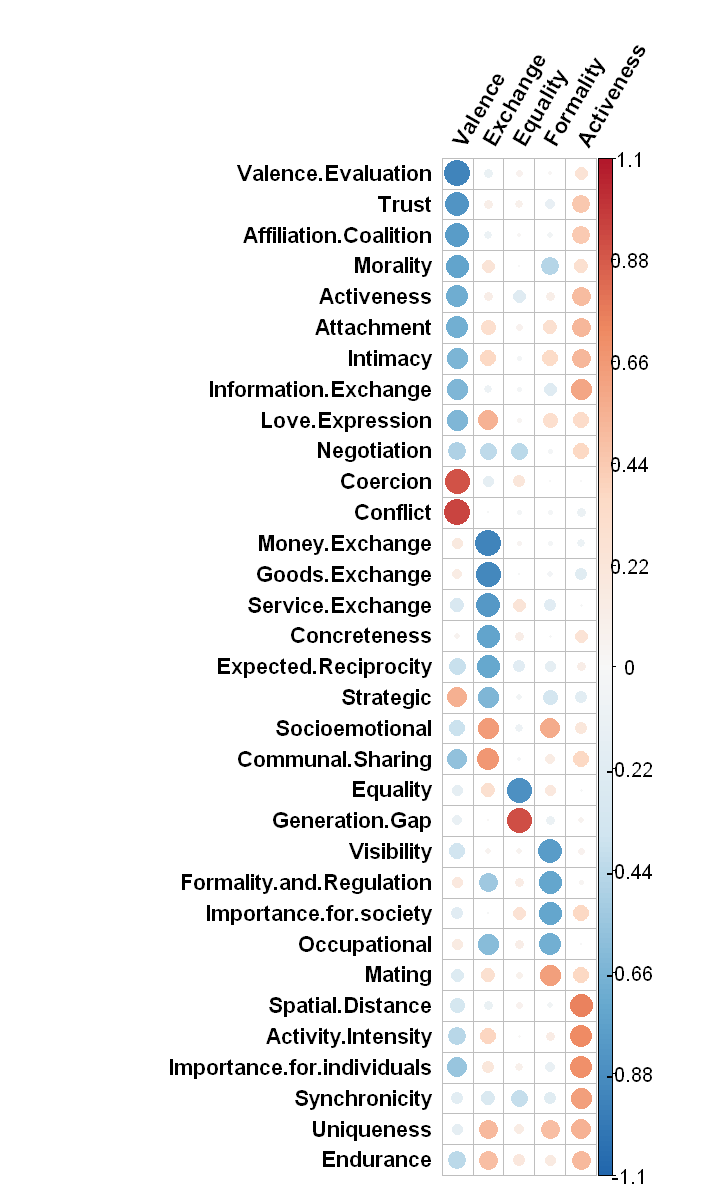

In [7]:
chn_FAVEE <- FAVEE(chn_data_scaled, c('Valence','Exchange','Equality','Formality','Activeness'))
chn_FAVEE_scores <- data.frame(chn_FAVEE[2])

# world data

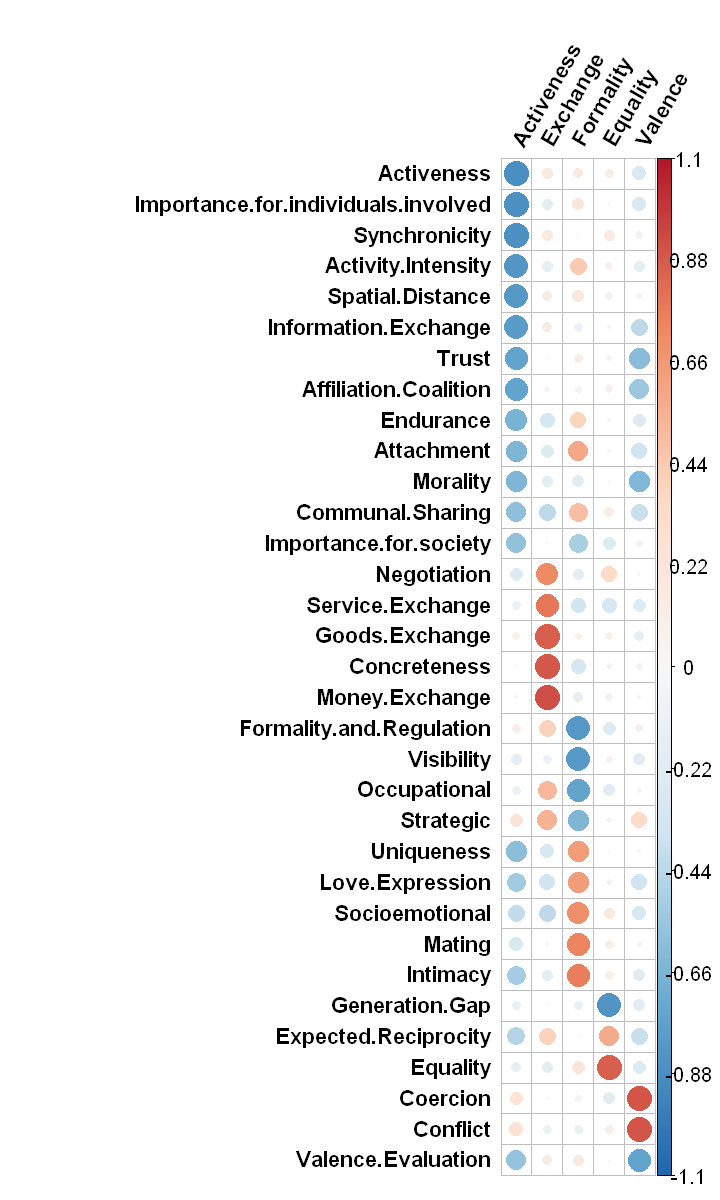

In [8]:
world_FAVEE <- FAVEE(world_data_scaled, c('Activeness','Exchange','Formality','Equality','Valence'))
world_FAVEE_scores <- data.frame(world_FAVEE[2])

# mosuo data

[1] 75 33

[1] 0.6137257 0.7394844 0.8041400 0.8438749 0.8818535

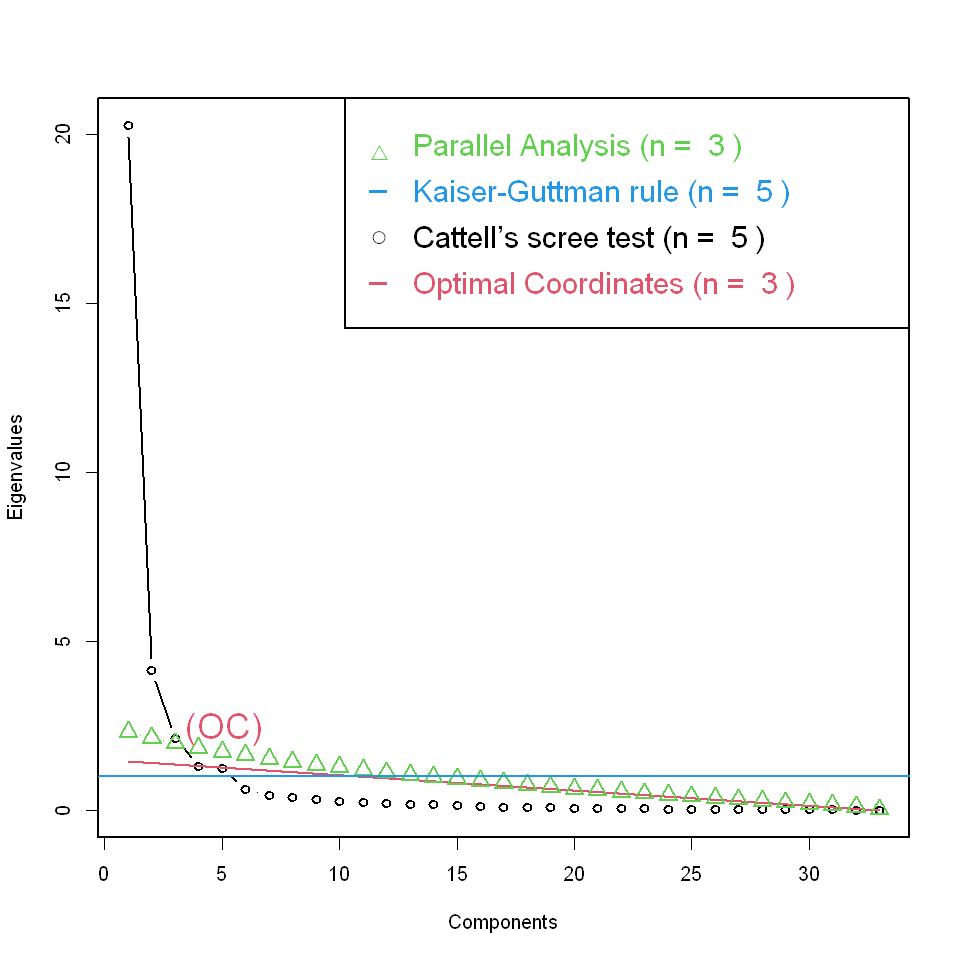

In [9]:
# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(mosuo_data_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(mosuo_data_scaled),var=ncol(mosuo_data_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, model = "components",aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05

dim(mosuo_data_scaled)
nS$Analysis$Cumu[1:5]

options(repr.plot.width=8,repr.plot.height=8)
plotnScree(nS, elbow = 5, legend=TRUE, main = NULL)

abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule

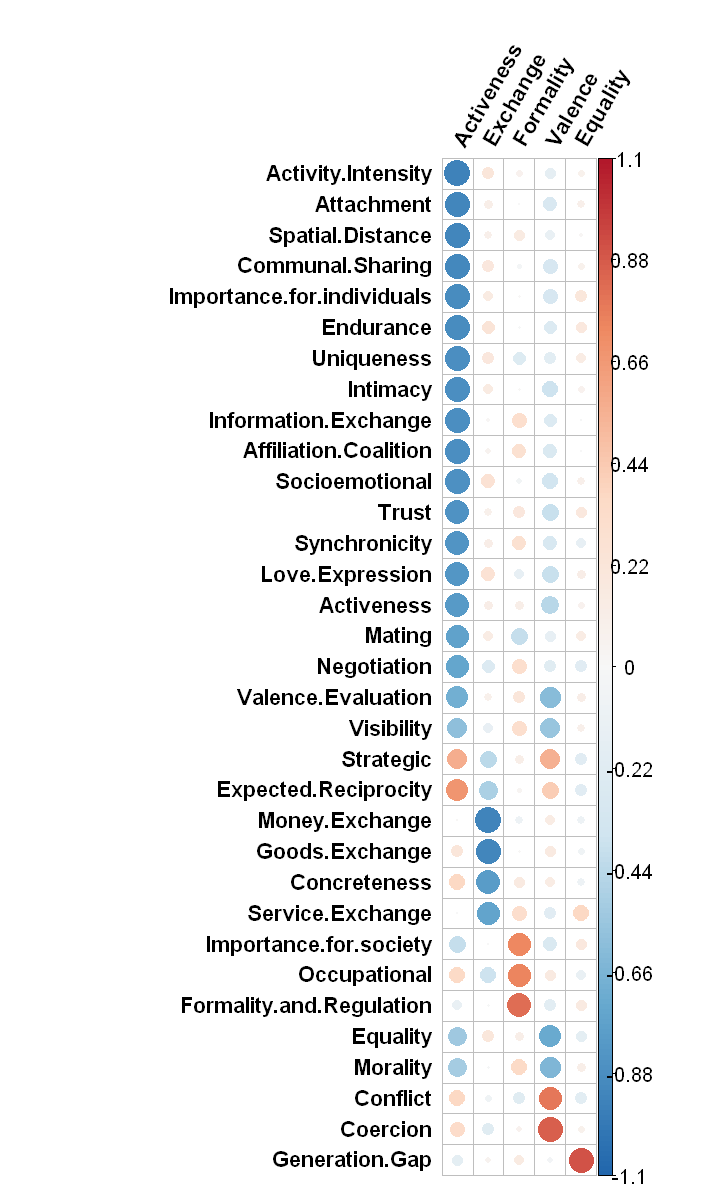

In [10]:
mosuo_FAVEE <- FAVEE(mosuo_data_scaled, c('Activeness','Exchange','Formality','Valence','Equality'))
mosuo_FAVEE_scores <- data.frame(mosuo_FAVEE[2])

[1] 66


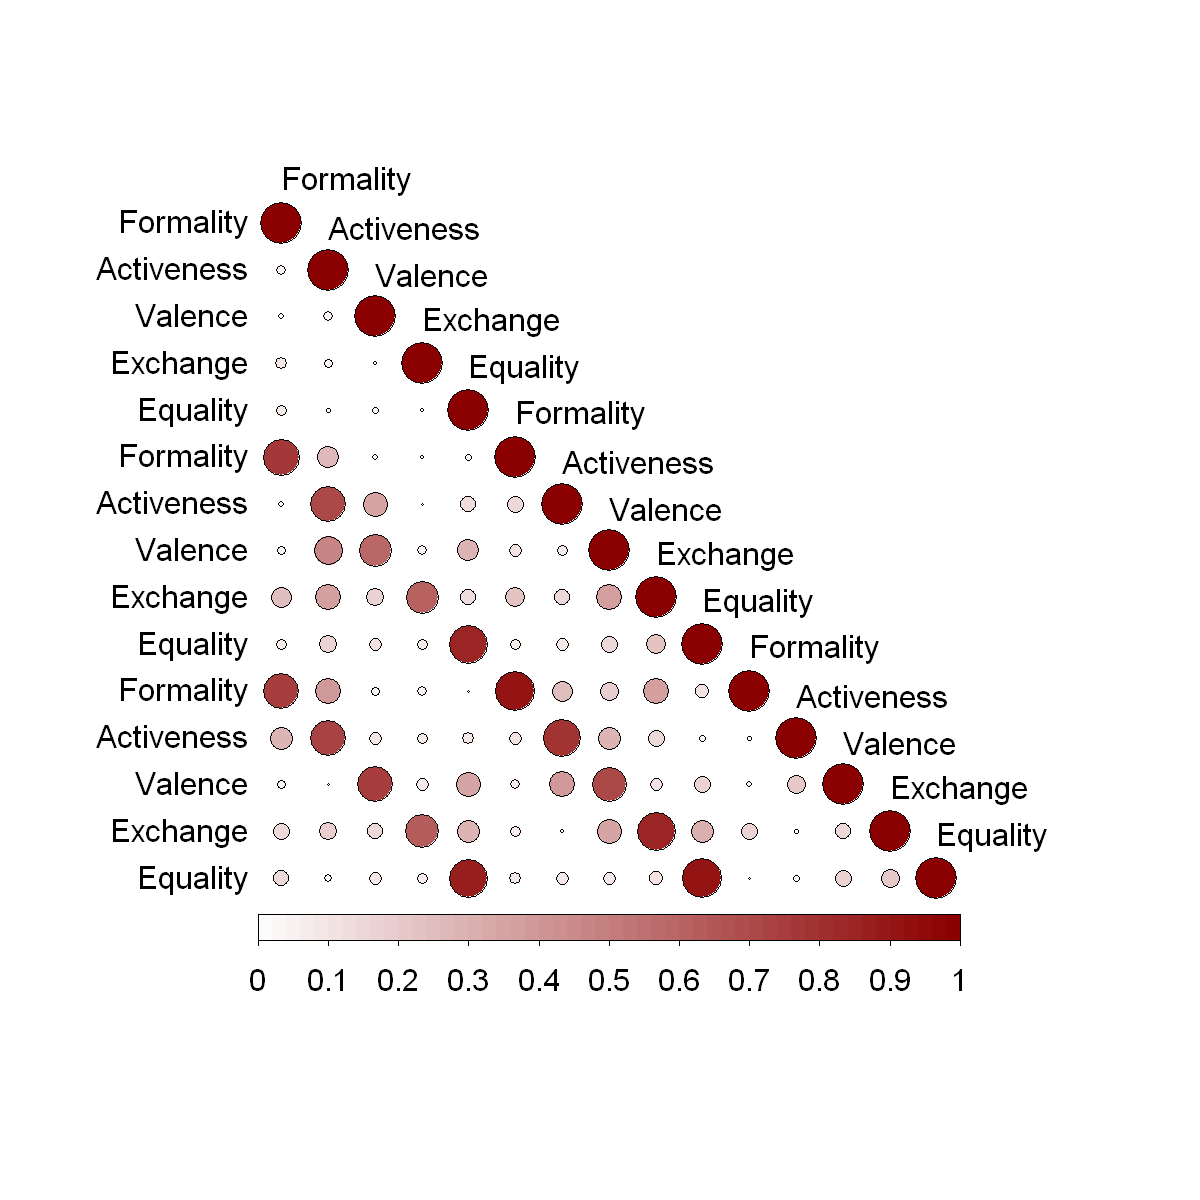

In [11]:
FAVEE_cor(mosuo_FAVEE_scores, chn_FAVEE_scores, world_FAVEE_scores, 'mosuo', 'chn', 'world')

# plot loadings

In [12]:
FAVEE = c('Formality','Activeness','Valence','Exchange','Equality')

dimensions_33d_order = c('Service Exchange', 'Valence Evaluation', 'Formality and Regulation', 'Spatial Distance', 'Mating','Morality','Expected Reciprocity',
'Goods Exchange','Coercion','Negotiation','Attachment','Communal Sharing','Socioemotional','Importance for society','Importance for individuals','Conflict',
'Concreteness','Occupational','Trust','Intimacy','Love Expression','Strategic','Activeness','Affiliation Coalition','Information Exchange','Visibility', 'Equality',
'Generation Gap', 'Money Exchange', 'Activity Intensity', 'Synchronicity', 'Endurance')

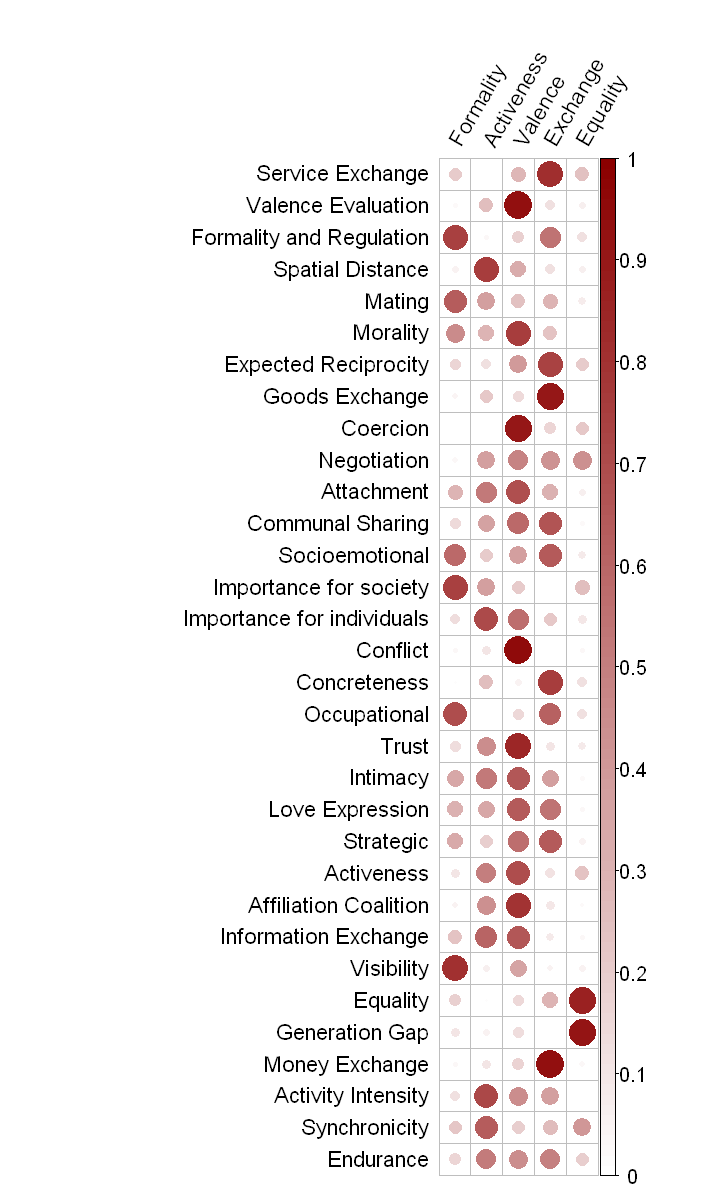

In [13]:
chn_loadings = data.frame(chn_FAVEE[1])
row_names <- rownames(chn_loadings)

new_row_names <- gsub("\\.", " ", row_names)

rownames(chn_loadings) = new_row_names

chn_loadings = chn_loadings[dimensions_33d_order,]

options(repr.plot.width=6,repr.plot.height=10)
loadings_var_reorder = abs(chn_loadings)

my.breaks = c(seq(0,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',#font=2,
         col.lim = c(0,1),cl.ratio = 0.4,cl.cex=1,
         col= colorRampPalette(c("white","darkred"))(100))

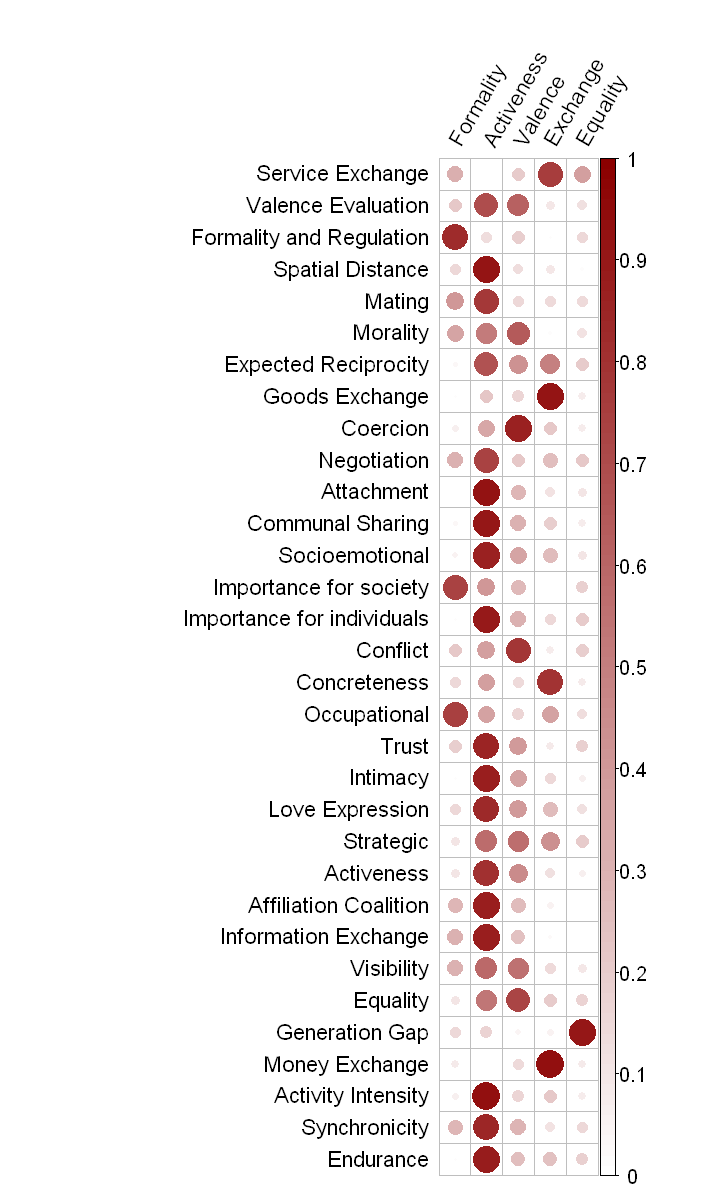

In [14]:
mosuo_loadings = data.frame(mosuo_FAVEE[1])
row_names <- rownames(mosuo_loadings)

new_row_names <- gsub("\\.", " ", row_names)

rownames(mosuo_loadings) = new_row_names

mosuo_loadings = mosuo_loadings[dimensions_33d_order,]

options(repr.plot.width=6,repr.plot.height=10)
loadings_var_reorder = abs(mosuo_loadings)

my.breaks = c(seq(0,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',
         col.lim = c(0,1),cl.ratio = 0.4,cl.cex=1,
         col= colorRampPalette(c("white","darkred"))(100))

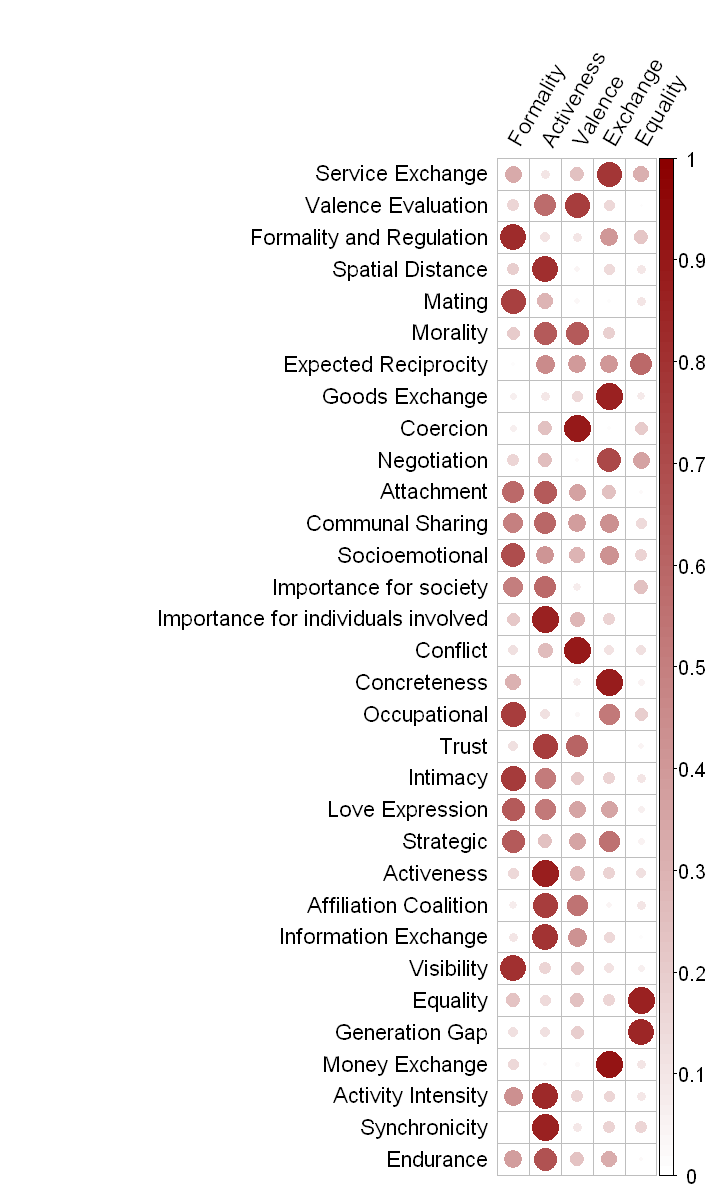

In [15]:
world_loadings = data.frame(world_FAVEE[1])
row_names <- rownames(world_loadings)

new_row_names <- gsub("\\.", " ", row_names)

rownames(world_loadings) = new_row_names

world_loadings = world_loadings[dimensions_33d_order,]

options(repr.plot.width=6,repr.plot.height=10)
loadings_var_reorder = abs(world_loadings)

my.breaks = c(seq(0,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',
         col.lim = c(0,1),cl.ratio = 0.4,cl.cex=1,
         col= colorRampPalette(c("white","darkred"))(100))